# Information Pursuit: A Wikispeedia Analysis

This notebook developes an in-depth analysis of the `Wikispeedia` dataset. The goal is to identify the characteristics of human navigation paths, and use this knowledge to produce useful insights on how to assess the difficulty of arbitrary pairs of articles, and the downfalls of common human strategies.

This study requires advanced inspection of the Wikispeedia network of pages, and the results collected from multiple thousand games.

This notebook is divided into four main parts:
1. Wikispeedia network analysis
2. Path Efficiency Analysis
3. Navigation Strategies

In [1]:
%load_ext autoreload
%autoreload 2

### Understanding the data

Before stepping into the analysis, we first describe briefly the data at hand. This also allows us to show a few transformations that have been done to ease data manipulation.

Load and transform some data to make it easy to use

In [2]:
from src.utils.data_utils import load_graph_data

graph_data = load_graph_data()

2024-11-15 15:37:31,712 - src.utils - INFO - loading raw data from tsv files...
2024-11-15 15:37:32,246 - src.utils - INFO - formatting articles...
2024-11-15 15:37:32,251 - src.utils - INFO - formatting categories...
2024-11-15 15:37:32,259 - src.utils - INFO - formatting links...
2024-11-15 15:37:32,380 - src.utils - INFO - formatting paths...
2024-11-15 15:37:32,771 - src.utils - INFO - formatting distance matrix...
2024-11-15 15:37:37,821 - src.utils - INFO - converting distance matrix to dataframe...
2024-11-15 15:37:44,418 - src.utils - INFO - building graph...


In [3]:
from src.utils.general_utils import describe_dict

describe_dict(graph_data)

Keyword                       | Type (shape)          
------------------------------------------------------
articles                        DataFrame (4604, 1)   
categories                      DataFrame (5204, 2)   
links                           DataFrame (119882, 2) 
paths_finished                  DataFrame (51318, 9)  
paths_unfinished                DataFrame (24875, 9)  
shortest-path-distance-matrix   DataFrame (319476, 1) 
graph                           DiGraph (4604, 124486)


### Why analysing human behaviors

In [4]:
# Show differences between paths and shortest paths

paths_info = graph_data["paths_finished"][["hashedIpAddress", "timestamp", "path_length", "source", "target"]].copy()
paths_info.sort_values(by="timestamp", inplace=True)

# only take first path of every player
paths_info = paths_info.groupby(["source", "target", "hashedIpAddress"], as_index=False).first()

paths_info = paths_info[["source", "target", "path_length"]]
paths_info = paths_info.groupby(["source", "target"]).describe()

paths_info["shortest_distance"] = graph_data["shortest-path-distance-matrix"]["optimal_path_length"]

# remove one special case where shortest_distance is nan
paths_info = paths_info[lambda df: ~df.shortest_distance.isna()]

paths_info

path_length                             \
                                          count       mean       std   min   
source       target                                                          
10th_century 11th_century                   3.0   2.000000  0.000000   2.0   
             Country                        1.0   3.000000       NaN   3.0   
14th_century African_slave_trade            3.0   7.333333  2.081666   5.0   
             Elizabeth_I_of_England         4.0   7.500000  5.744563   4.0   
             Fire                           1.0   4.000000       NaN   4.0   
...                                         ...        ...       ...   ...   
Zirconium    Hebrew_calendar                1.0   5.000000       NaN   5.0   
             Magna_Carta                    1.0   4.000000       NaN   4.0   
             Robinson_Crusoe                1.0  10.000000       NaN  10.0   
             United_Kingdom                 1.0   4.000000       NaN   4.0   
             Ununbium                       1.0   3.000000       NaN   3.0   

                                                            shortest_distance  
                                      25%   50%   75%   max                    
source       target                                                            
10th_century 11th_century             2.0   2.0   2.0   2.0               1.0  
             Country                  3.0   3.0   3.0   3.0               2.0  
14th_century African_slave_trade      6.5   8.0   8.5   9.0               3.0  
             Elizabeth_I_of_England   4.0   5.0   8.5  16.0               2.0  
             Fire                     4.0   4.0   4.0   4.0               3.0  
...                                   ...   ...   ...   ...               ...  
Zirconium    Hebrew_calendar          5.0   5.0   5.0   5.0               3.0  
             Magna_Carta              4.0   4.0   4.0   4.0               3.0  
             Robinson_Crusoe         10.0  10.0  10.0  10.0               4.0  
             United_Kingdom           4.0   4.0   4.0   4.0               2.0  
             Ununbium                 3.0   3.0   3.0   3.0               2.0  

[5585 rows x 9 columns]

<Axes: title={'center': 'Comparison of encountered vs optimal path lengths'}, xlabel='Average path length of players', ylabel='Optimal length'>

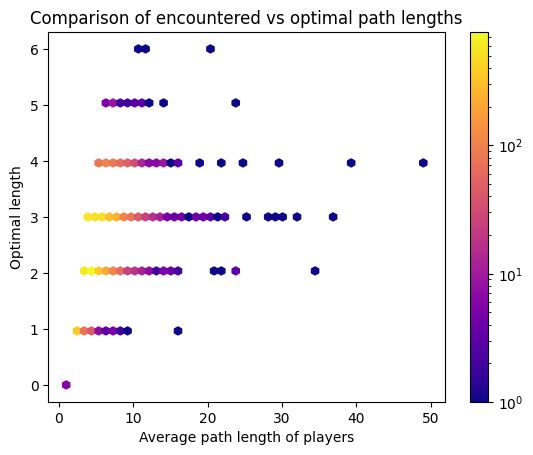

In [5]:
paths_info.plot.hexbin(
	x=("path_length", "mean"),
	y="shortest_distance",
	title="Comparison of encountered vs optimal path lengths",
	xlabel="Average path length of players",
	ylabel="Optimal length",
	gridsize=50,
	bins="log",
	cmap="plasma",
)

In [6]:
from scipy import stats

print(stats.pearsonr(paths_info[("path_length", "mean")], paths_info["shortest_distance"]))

PearsonRResult(statistic=0.4813748619406178, pvalue=5.93e-322)


## Wikispeedia network analysis

It seems quite reasonable to hypothetized that humans navigate the pages of the Wikispeedia website based on relationships existing between the target article concept and the content of the articles found along the way. In order to reason about these semantic relations, humans abstract ideas and form their inner world model, making internalizing concepts efficient and smooth.

In this analysis, we verify if an intuitive top-down approach is indeed the most prevalent strategy of the players.

*Do players have a tendancy to over-utilize hubs of the Wikispeedia networks?*\
*Is this strategy usually paying-off?*

In [7]:
import networkx as nx
import numpy as np


def compute_hubs(graph):
	hubs = nx.hits(graph, normalized=True)[0]

	distribution = np.array([*hubs.values()])
	mean = np.mean(distribution)
	std = np.std(distribution)

	# check positive outliers in the hub values
	significant_hubs = list(filter(lambda t: t[1] - mean > 8 * std, hubs.items()))
	significant_hubs = sorted(significant_hubs, key=lambda t: t[1], reverse=True)

	return significant_hubs

In [8]:
compute_hubs(graph_data["graph"])

[('Driving_on_the_left_or_right', 0.0013171632208290852)]

In [9]:
# TODO: Fred code.

## Path Efficiency Analysis

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut fermentum pretium nibh quis accumsan. In at nunc mauris. Integer varius ante non massa pharetra auctor. Interdum et malesuada fames ac ante ipsum primis in faucibus. Sed sit amet commodo nunc. Nulla felis enim, lobortis ut pharetra quis, bibendum sed nunc. Quisque accumsan sapien ac vehicula pretium. Maecenas quis tellus hendrerit, bibendum felis at, iaculis odio. Nullam sed fringilla lorem. Morbi nunc orci, fringilla vel semper dapibus, blandit quis lacus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas.


   - Compare actual paths with shortest paths found computationally
   - Develop metrics for path "efficiency" considering both length and completion time
   - Create visualization tools for path comparison and analysis
   - Analyze distribution of successful vs. abandoned paths

In [10]:
# TODO: Peter code

# p-values and stuff. logits

In [11]:
# TODO: Gabriel code

# Graphs and stuff
# people tired => people bad

## Navigation Strategies

It seems quite reasonable to hypothetized that humans navigate the pages of the Wikispeedia website based on relationships existing between the target article concept and the content of the articles found along the way. In order to reason about these semantic relations, humans abstract ideas and form their inner world model, making internalizing concepts efficient and smooth.

In this analysis, we verify if an intuitive top-down approach is indeed the most prevalent strategy of the players.

*Do players have a tendancy to over-utilize hubs of the Wikispeedia networks?*\
*Is this strategy usually paying-off?*

### Top-down approach

Represent user paths as a graph

In [13]:
from src.data.graph import extract_players_graph

finished_paths_graph = extract_players_graph(graph_data, paths_finished=True)
unfinished_paths_graph = extract_players_graph(graph_data, paths_finished=False)

ImportError: cannot import name 'str' from 'typing' (C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\typing.py)

In [ ]:
compute_hubs(finished_paths_graph)

[('United_States', 0.03252328407986499),
 ('Europe', 0.019288972404555495),
 ('United_Kingdom', 0.015584267109294218),
 ('England', 0.014512061177973046),
 ('North_America', 0.01376374273367645),
 ('Earth', 0.012658182958466225),
 ('World_War_II', 0.009468624468380454),
 ('English_language', 0.008884412977769693),
 ('Great_Britain', 0.007144918668458417),
 ('France', 0.0071205427603357)]

In [ ]:
compute_hubs(unfinished_paths_graph)

[('United_States', 0.02245843005865249),
 ('United_Kingdom', 0.01118949329937272),
 ('England', 0.010328107713851743),
 ('Europe', 0.009365067575018654),
 ('Animal', 0.008076413290830507),
 ('North_America', 0.008043926762033967),
 ('Mammal', 0.007004155538156377),
 ('World_War_II', 0.0066776362305523895),
 ('English_language', 0.006385391170843087),
 ('Earth', 0.005854865711796787)]

# Strategy : how to find unrelated specific articles

The game sometimes contains some totally unrelated articles that have no direct links. One human strategy would be to find use more general concepts to bridge these two articles.
For example when browsing from Picasso to Theory of Relativity, it might be easier to go from Picasso to Spain, even if Spain is not closer to Theory of Relativity. Because Spain is a more general article, it might be easier to find a link to Science for example.

To test this hypothesis we first link the articles to their pagerank scores, which we normalize.
After that we will plot the average path and how the generality of the articles behave.

In [16]:
from src.utils.data_utils import load_graph_data
import pandas as pd
# Load the data
graph_data = load_graph_data()
paths_finished = graph_data['paths_finished']

In [ ]:
#Pagerank algorithm
pagerank_scores = nx.pagerank(graph_data['graph'], alpha=0.85)
graph_pagerank = pd.DataFrame(list(pagerank_scores.items()), columns=['Article', 'PageRank'])
#Normalizing
graph_pagerank['Generality_score'] = (graph_pagerank['PageRank'] - graph_pagerank['PageRank'].min()) / (graph_pagerank['PageRank'].max()-graph_pagerank['PageRank'].min())

In [18]:
article_gen_score = graph_pagerank.set_index('Article')['Generality_score']

# Get path finished and filter so that we only keep short paths (other are noise)
paths_finished = graph_data['paths_finished']
paths_finished = paths_finished[paths_finished['path'].apply(len) <= 20]

#Remove < from path (but keep the articles that the person attempted to go to)
paths_finished['path'] = paths_finished['path'].apply(lambda x: [u for u in x if u != '<'])


paths_finished['Generality_score'] = paths_finished['path'].apply(
    lambda path: article_gen_score.loc[path].tolist()
)

C:\Users\calle\AppData\Local\Temp\ipykernel_17608\3360916035.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished['path'] = paths_finished['path'].apply(lambda x: [u for u in x if u != '<'])
C:\Users\calle\AppData\Local\Temp\ipykernel_17608\3360916035.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished['Generality_score'] = paths_finished['path'].apply(


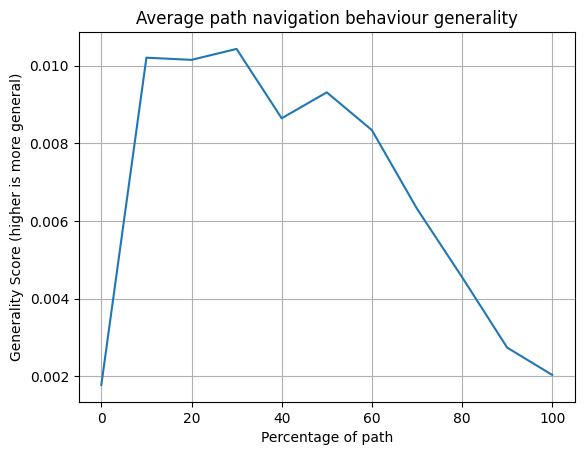

In [21]:
import matplotlib.pyplot as plt

NUMBER_OF_BINS = 10

scores_bins = [[] for _ in range(NUMBER_OF_BINS+1)]

#We have bins for every steps then add the scores that fall in that bin
#For ex. if the path is of length 5 we will add step 1 to 1st bin, step 2 to 3rd, etc...
for _, path in paths_finished.iterrows():
    #This is the previously computed path of generality scores (for each step)
    generality_scores = path['Generality_score']
    bins = np.linspace(0, 1, len(generality_scores))

    for fraction, score in zip(bins, generality_scores):
        bin_index = int(fraction * NUMBER_OF_BINS) #Find bin where this falls
        scores_bins[bin_index].append(score)

scores = [np.mean(scores) for scores in scores_bins]

percent = [(100*i / NUMBER_OF_BINS) for i in range(NUMBER_OF_BINS+1)]


plt.plot(percent, scores)
plt.xlabel('Percentage of path')
plt.ylabel('Generality Score (higher is more general)')
plt.title('Average path navigation behaviour generality')
plt.grid(True)
plt.show()

We see that on average, while the first and last articles are very specific, the middle articles are more general, confirming our hypothesis.
We also see that there is a decrease in generality towards the end when the player probably has a specific path in mind of how to join that article

## Link clicking strategy

Because the players are playing under time pressure, we assume they don't have time to look at the whole articles before making a selection. Therefore we state the hypothesis that players are clicking mostly on the first links that appear on the page.
The links are ordered lexicographically so we need to scan the html files to find the order of the links. Then we will normalize by the number of links on the page and look at the proportion of clicks that happen in the top 20% of the page and in the last 80%.


In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils.data_utils import load_graph_data
from src.utils.data_utils import get_links_from_html_files

graph_data = load_graph_data()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
all_links_dict = get_links_from_html_files()
for article, links in all_links_dict.items():
    for link in links:
        #Normalize to get relative position
        link['position'] = link['position']/len(links)


starting...


In [ ]:
click_positions_fin = []
click_positions_unfin = []
paths_finished = graph_data['paths_finished']
paths_unfinished = graph_data['paths_unfinished']

def get_click_positions(paths_df, all_links_dict, c):
    for _,row in paths_df.iterrows():
        path = row['path']
        for i in range(len(path) - 1):
            before = path[i]
            next = path[i + 1]

            if before in all_links_dict:
                for link in all_links_dict[before]:
                    if link.get('title') == next:
                        if 'position' in link:
                            c.append(link['position'])
                        break

get_click_positions(paths_finished, all_links_dict, click_positions_fin)
get_click_positions(paths_unfinished, all_links_dict, click_positions_unfin)

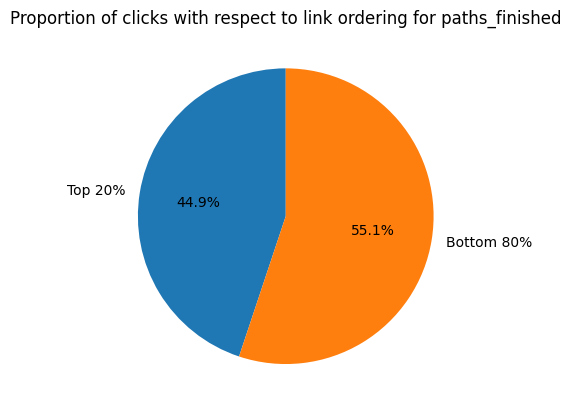

In [ ]:
import matplotlib.pyplot as plt

top_links = [pos for pos in click_positions_fin if pos <= 0.2]
otherlinks = [pos for pos in click_positions_fin if pos > 0.2]

total_clicks = len(click_positions_fin)
top = len(top_links) / total_clicks
bottom = len(otherlinks) / total_clicks


labels = ['Top 20%', 'Bottom 80%']
sizes = [len(top_links), len(otherlinks)]
#Plot results as a pie with percentage, to add precision change x.2f

plt.pie(sizes, labels=labels, autopct=lambda x: f"{x:.1f}%", startangle=90)
plt.title('Proportion of clicks with respect to link ordering for paths_finished')
plt.show()


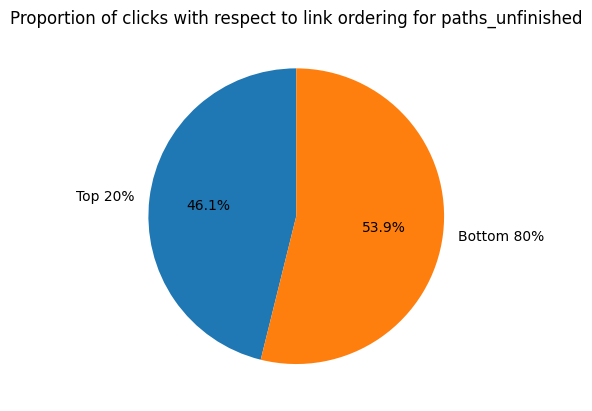

In [ ]:
import matplotlib.pyplot as plt

top_links = [pos for pos in click_positions_unfin if pos <= 0.2]
otherlinks = [pos for pos in click_positions_unfin if pos > 0.2]

total_clicks = len(click_positions_unfin)
top = len(top_links) / total_clicks
bottom = len(otherlinks) / total_clicks


labels = ['Top 20%', 'Bottom 80%']
sizes = [len(top_links), len(otherlinks)]
#Plot results as a pie with percentage, to add precision change x.2f
plt.pie(sizes, labels=labels, autopct=lambda x: f"{x:.1f}%", startangle=90)
plt.title('Proportion of clicks with respect to link ordering for paths_unfinished')
plt.show()


It appears that both paths that are finished and unfinished click mostly on links in the top of the page (45% instead of expected 20% if the players scanned the whole page and articles importance was disseminated at random.) Note that the slightly higher percentage of top clicks in paths_unfinished may mean that unsuccessful players are more naive, but this hypothesis needs to be tested more in detail because the difference is so small.


## Conclusion

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut fermentum pretium nibh quis accumsan. In at nunc mauris. Integer varius ante non massa pharetra auctor. Interdum et malesuada fames ac ante ipsum primis in faucibus. Sed sit amet commodo nunc. Nulla felis enim, lobortis ut pharetra quis, bibendum sed nunc. Quisque accumsan sapien ac vehicula pretium. Maecenas quis tellus hendrerit, bibendum felis at, iaculis odio. Nullam sed fringilla lorem. Morbi nunc orci, fringilla vel semper dapibus, blandit quis lacus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas.